In [1]:
# general imports
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime ,timedelta
from pandas.tseries.offsets import MonthEnd

from sklearn.metrics import mean_squared_error

# for data read
import pickle
import os

# time series model
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Prophet
import prophet as pt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Manual Inputs
# We choose dates between 2010 and 2019 as this 10 year period has no major financial global crises
# We intend to use 9 years (2010-2018) for training, and 1 year (2019) for testing

#root_dir          = r'C:\Users\wsteynber\_Data Science'
root_dir          = r'c:\Users\Zoli\Downloads\python\academy'
price_metric      = 'Open'
filt_date_min     = datetime(2010,1,1)
filt_date_max     = datetime(2019,1,1) + MonthEnd(0) + timedelta(days=1)
filt_date_min_ext = filt_date_min - timedelta(days=10) # extra days used for linear interpolation
filt_date_max_ext = filt_date_max + timedelta(days=10) # extra days used for linear interpolation

In [3]:
# Time Series Data

df_ts         = pd.read_pickle(root_dir + r'\50yr_timeSeries_data.pkl')

df_ts         = df_ts.loc[: ,(slice(None) ,[price_metric])]
df_ts.columns = df_ts.columns.droplevel(1)

filt          = ((filt_date_min_ext <= df_ts.index) & (df_ts.index < filt_date_max_ext))
df_ts         = df_ts.loc[filt]

In [4]:
# No data on weekends and other days (possibly public holidays?)
# ie 2010-01-01 to 2010-01-03 missing
# ie 2010-01-09 to 2010-01-10 missing ... and so on

df_ts[:20].index

DatetimeIndex(['2009-12-22', '2009-12-23', '2009-12-24', '2009-12-28',
               '2009-12-29', '2009-12-30', '2009-12-31', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15', '2010-01-19', '2010-01-20', '2010-01-21'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [5]:
# Create DataFrame with every day of the week
# Use linear interpolation to populate, where possible, missing values
# Remove dates (indexes) that were just there for linear interpolation purposes

df_all_dates = pd.DataFrame(pd.date_range(filt_date_min_ext ,filt_date_max_ext ,freq='d') ,columns=['Date']).set_index(['Date'])

df_ts_0 = pd.concat([df_all_dates ,df_ts] ,axis=1)
df_ts_0 = df_ts_0.interpolate(limit_direction='forward')

filt    = ((filt_date_min <= df_ts_0.index) & (df_ts_0.index < filt_date_max))
df_ts_0 = df_ts_0[filt]

df_ts_0.head(10)

,TRGP,FDS,SYY,RCL,PSA,FISV,HUM,SNA,EMR,CAT,...,INTC,KDP,ADP,WMB,CCL,ATVI,DLTR,DLR,FE,ODFL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,66.532499,28.327501,25.622500,82.622503,12.270625,44.475001,42.897501,43.187501,57.612499,...,20.647501,28.740000,38.219930,17.453432,32.192500,11.32,16.184166,50.110001,47.227500,9.162963
2010-01-02,NaN,66.424999,28.285001,25.795000,82.335003,12.266250,44.460001,42.845001,43.175001,57.625000,...,20.695001,28.670000,38.222124,17.461584,32.225000,11.29,16.181666,50.200001,47.025000,9.140741
2010-01-03,NaN,66.317499,28.242501,25.967500,82.047503,12.261875,44.445001,42.792501,43.162501,57.637501,...,20.742501,28.600000,38.224319,17.469736,32.257501,11.26,16.179166,50.290001,46.822499,9.118519
2010-01-04,NaN,66.209999,28.200001,26.139999,81.760002,12.257500,44.430000,42.740002,43.150002,57.650002,...,20.790001,28.530001,38.226513,17.477888,32.290001,11.23,16.176666,50.380001,46.619999,9.096296
2010-01-05,NaN,66.750000,28.010000,26.110001,79.870003,12.312500,45.790001,42.630001,43.380001,58.549999,...,20.940001,28.959999,37.445126,17.534952,32.279999,11.24,16.013332,50.029999,46.650002,8.642963
2010-01-06,NaN,67.430000,27.889999,25.900000,80.730003,12.355000,45.660000,42.840000,43.250000,59.180000,...,20.809999,28.900000,37.576820,17.909945,32.290001,11.26,16.253332,50.660000,46.299999,8.847407
2010-01-07,NaN,67.470001,28.010000,25.469999,79.879997,12.315000,46.250000,42.860001,43.599998,59.299999,...,20.730000,29.100000,36.988586,18.390911,32.119999,11.10,16.680000,49.680000,46.570000,8.782222
2010-01-08,NaN,68.029999,28.080000,25.750000,79.639999,12.147500,47.810001,43.580002,43.730000,59.250000,...,20.540001,28.549999,37.243195,18.268633,32.820000,10.97,16.536667,50.119999,45.950001,8.681481
2010-01-09,NaN,68.056666,28.076667,25.856667,79.506666,12.161667,47.700001,44.000001,43.896666,59.816667,...,20.730001,28.639999,37.243195,18.352870,33.076667,10.95,16.523334,50.476665,45.993334,8.700247


Text(0.5, 1.0, 'Distribution of NaN values by Stock')

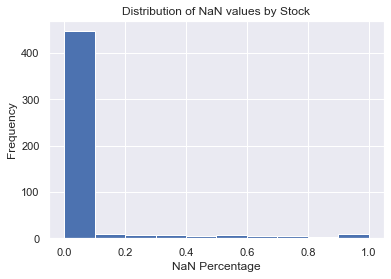

In [6]:
# Check NaN values
# After linear interpolation only an extremely small percentage of stocks had NaN price values

df_stock_nan = pd.DataFrame(df_ts_0.isna().sum() ,columns=['nan_cnt'])

df_stock_nan['nan_perc'] = df_stock_nan['nan_cnt'] / len(df_ts_0)

ax = df_stock_nan['nan_perc'].plot.hist()
ax.set_xlabel('NaN Percentage')
ax.set_title('Distribution of NaN values by Stock')

In [7]:
# Drop stocks with > 50% NaN price values as they contain very little information
# For the remainder set NaN values equal to stock mean

filt = (df_stock_nan['nan_perc'] > 0.5)
lst_nan_stocks_drop = df_stock_nan.loc[filt].index

df_ts_1 = df_ts_0.drop(columns=lst_nan_stocks_drop ,axis=1).copy()
df_ts_1 = df_ts_1.fillna(df_ts_1.mean())

print('NaN values remaining: ' ,max(df_ts_1.isna().sum()))

NaN values remaining:  0


In [8]:
# Import dictionary of all the alternative portfolios
# The stocks dropped above (lst_nan_stocks_drop) are present in the alternative portfolios
# Excluding the dropped stocks the alternative portfolios and time series data have strictly the same stocks

with open(root_dir + r'\alternate_port.pkl' ,'rb') as pickle_in:
    dict_alt_port = pickle.load(pickle_in)

lst_alt_port_stocks = dict_alt_port['cluster_0'].index.tolist() # cluster_0 is the first alternative portfolio and contains all stocks (see clustering for further detail)
lst_df_ts_stocks    = df_ts_1.columns.tolist()

print('Number of stocks in alternative portfolios but not in time series data:' ,len(set(lst_alt_port_stocks) - set(lst_df_ts_stocks)))
print('Of which are non-dropped stocks:'                                        ,len(set(lst_alt_port_stocks) - set(lst_df_ts_stocks) - set(lst_nan_stocks_drop)))

Number of stocks in alternative portfolios but not in time series data: 28
Of which are non-dropped stocks: 0


In [9]:
# Remove dropped stocks from all alternative portfolios

dict_alt_port_0 = dict_alt_port.copy()

for i in range(len(dict_alt_port_0)):
    lst_tmp_keep_stocks             =  list(set(dict_alt_port_0[f'cluster_{i}'].index) - set(lst_nan_stocks_drop))
    dict_alt_port_0[f'cluster_{i}'] = dict_alt_port_0[f'cluster_{i}'].loc[lst_tmp_keep_stocks]
    # print('From' ,len(dict_alt_port[f'cluster_{i}'].index) ,'to' ,len(dict_alt_port_0[f'cluster_{i}'].index))

In [10]:
# Remove redundant columns from all alternative portfolios

lst_drop_col  = [f'cluster_{i}' for i in range(len(dict_alt_port_0))] # These columns were used for clustering and are redundant for the time series piece
lst_drop_col += ['overall_score' ,'_rn']

for i in range(len(dict_alt_port_0)):
    dict_alt_port_0[f'cluster_{i}'] = dict_alt_port_0[f'cluster_{i}'].drop(lst_drop_col ,axis=1)

In [11]:
# Visual to check that the shrunken version of the alternative portfoios do not have too few stocks in them
# The alternative portfolio cluster_13 has nan values

lst_nan_cols = []

df_tmp_idx = pd.DataFrame(index=dict_alt_port_0['cluster_0']['cluster'].drop_duplicates())

for i in range(len(dict_alt_port_0)):
    df_tmp = pd.DataFrame(dict_alt_port_0[f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}'})
    df_tmp = pd.concat([df_tmp_idx ,df_tmp] ,axis=1)
    lst_nan_cols += df_tmp.columns[df_tmp.isna().any()].tolist()

lst_nan_cols

['alt_port_13']

In [12]:
# Investigate what can be done for the nan value in alternative portfolio cluster_13
# We see there's only a single nan value in alternative portfolio 13 at cluster 23

df_tmp = pd.DataFrame(index=dict_alt_port_0['cluster_0']['cluster'].drop_duplicates())

for i in range(12,14,1): #range(len(dict_alt_port_0)):
    df_tmp_frm = pd.DataFrame(dict_alt_port  [f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}_pre'})
    df_tmp_to  = pd.DataFrame(dict_alt_port_0[f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}_post'})
    df_tmp = pd.concat([df_tmp ,df_tmp_frm ,df_tmp_to] ,axis=1)

df_tmp.index.name = 'cluster'
df_tmp.loc[df_tmp['alt_port_13_post'].isna()]

,alt_port_12_pre,alt_port_12_post,alt_port_13_pre,alt_port_13_post
cluster,,,,
23,2,1,1,NaN


In [13]:
# Problem notes:
#     From the above, cluster 23 has the nan value
#     "_pre"  in alt_port_#_pre  means the number of stocks in the cluster prior to  the data cleaning (column drop) above
#     "_post" in alt_port_#_post means the number of stocks in the cluster following the data cleaning (column drop) above

# Problem for cluster 23:
#     alt_port_12_pre  = 2 means the alternative portfolio had 2 stocks
#     alt_port_12_post = 1 means one of these stocks were dropped as part of the data cleaning above
#     alt_port_13_pre  = 1 means 1 stock was chosen out of the 2 in alt_port_12_pre
#     alt_port_13_post = 0 means the stock in alt_port_13_pre was dropped

# Solution for cluster 23:
#    use the stock in alt_port_12_pre that wasn't dropped (ie not in alt_port_12_post) in alt_port_13_post
#    this should work since we know alt_port_12_post

filt   = (dict_alt_port  ['cluster_12']['cluster'] == 23)
filt_0 = (dict_alt_port_0['cluster_12']['cluster'] == 23)

lst_solution_stock = list(  set(dict_alt_port['cluster_12'].loc[filt].index.tolist())
                          - set(dict_alt_port['cluster_13'].loc[filt].index.tolist()))
lst_solution_stock

df_solultion_stock = dict_alt_port['cluster_12'].loc[filt].loc[lst_solution_stock]
df_solultion_stock

print(lst_solution_stock in lst_nan_stocks_drop.tolist()) # why was here (~

dict_alt_port_1 = dict_alt_port_0.copy()
dict_alt_port_1['cluster_13'] = pd.concat([dict_alt_port_1['cluster_13'] ,df_solultion_stock])

False


In [14]:
# Check that the fix worked and all clusters in the shrunked alternative portfolios have stocks in them
# And double check that the stock used for the fix is not included in the list of stocks that were/should be dropped
# List is empty, ie fix worked

lst_nan_cols = []

df_tmp_idx = pd.DataFrame(index=dict_alt_port_1['cluster_0']['cluster'].drop_duplicates())

for i in range(len(dict_alt_port_1)):
    df_tmp = pd.DataFrame(dict_alt_port_1[f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}'})
    df_tmp = pd.concat([df_tmp_idx ,df_tmp] ,axis=1)
    
    lst_nan_cols += df_tmp.columns[df_tmp.isna().any()].tolist()

print('Columns with nan values:' ,lst_nan_cols)
print('Is the stock used for the fix one that should be dropped:' ,lst_solution_stock in lst_nan_stocks_drop.tolist())

Columns with nan values: []
Is the stock used for the fix one that should be dropped: False


In [15]:
# Calculate weights to apply to each stock over all alternative portfolios

from sklearn.preprocessing  import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# # Calculate the daily returns of each stock
returns = df_ts_1.pct_change().dropna()

# # Normalize the returns using a MinMaxScaler
scaler = MinMaxScaler()
scaled_returns = scaler.fit_transform(returns)
scaled_returns = pd.DataFrame(scaled_returns ,index=returns.index ,columns=returns.columns)

# # Split the data into training and testing sets
train_size = int(len(scaled_returns) * 0.8)
train_data ,test_data = scaled_returns[:train_size] ,scaled_returns[train_size:]

# # Define the input and output data for the neural network
X_train ,y_train = train_data[:-1] ,train_data[1:]
X_test  ,y_test  = test_data [:-1] ,test_data [1:]

# # Define and train the neural network
model = MLPRegressor(hidden_layer_sizes=(32,16) ,activation='relu' ,solver='adam' ,random_state=42)
model.fit(X_train ,y_train)

# # Use the trained neural network to predict the optimal weights for the testing data
predicted_weights = model.predict(X_test)
predicted_weights = predicted_weights[-1] / np.sum(predicted_weights[-1])
predicted_weights = pd.DataFrame(predicted_weights ,index=X_test.columns ,columns=['weight'])

predicted_weights.head(10)

,weight
TRGP,0.002837
FDS,0.002204
SYY,0.002406
RCL,0.002054
PSA,0.001692
FISV,0.001733
HUM,0.001478
SNA,0.002095
EMR,0.001665
CAT,0.002298


In [16]:
# Calculate price for test alternative portfolio using pedicted weights

df_ts_2    = df_ts_1[sorted(df_ts_1.columns)].copy()
np_weights = np.array(predicted_weights.sort_index()).reshape(-1,)

df_tmp_port = pd.DataFrame(df_ts_2.values.dot(np_weights) ,index=df_ts_2.index)
df_tmp_port

,0
Date,
2010-01-01,39.627022
2010-01-02,39.594320
2010-01-03,39.561618
2010-01-04,39.528916
2010-01-05,39.204699
...,...
2019-01-27,109.226884
2019-01-28,108.898354
2019-01-29,109.696490


In [17]:
df =df_tmp_port

In [18]:
def split_df_prediciton(_df=df, _resampling='None'):
    """
    spit the last one year from data frame (input: _df)
    we assumed that data is daily
    input: 
        _df = df, input data frame in time series format (index is time, one column with data)
        _resampling='None' could be 'None', '1W' or '1M', ie. scales down horizon accordingly
    outputs:
        df_train, df_test: splited df
    """
    
    # params
    if _resampling == '1M':
        horizons = 12 
    elif _resampling == '1W':
        horizons = 52
    elif _resampling == 'None':
        horizons = 52*5 
    else:
        # todo proper error handling, now default is used
        horizons = 52*5

    split_point = _df.shape[0] - horizons
    df_train, df_test = _df[:split_point],_df[split_point:]

    return df_train, df_test

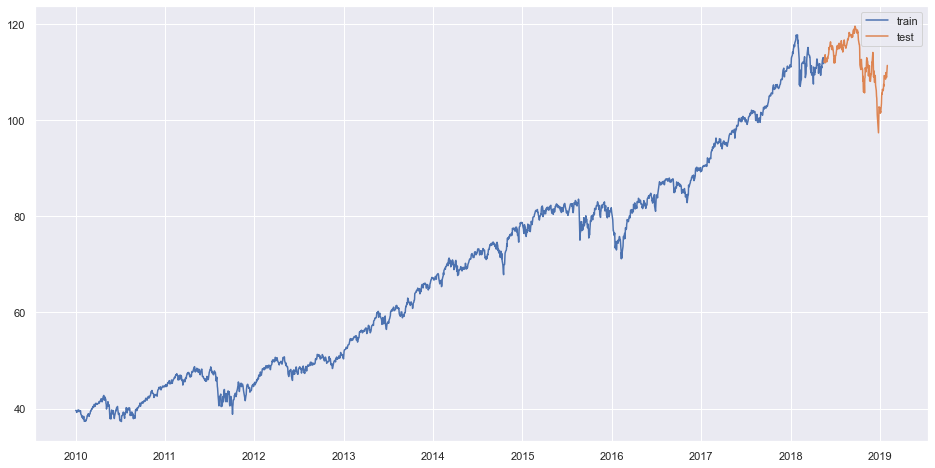

In [19]:
df_train, df_test = split_df_prediciton(df, _resampling='None')

plt.figure(figsize=(16,8))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test');
plt.legend();

In [20]:
def ts_analysis(_df = df, _resampling='1W', _debug=False, _method = 0, _plot = True, 
                _export = False, 
                _export_filename='ts_model_save.sav'):
    """
    classicial time series method used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0, not used
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months
        steps = 12
    elif _resampling == '1W':
        lags = 156
        steps = 52
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52
    
    # train test split
    df_train, df_test = split_df_prediciton(_df, _resampling='None')

    # resampling 
    df_train_resampled = df_train.resample(_resampling).mean() 
    df_test_resampled = df_test.resample(_resampling).mean()
    
    # overwrite steps
    steps = df_test_resampled.shape[0]
    
    # plot - if _debug is True
    if _debug == True:
        plt.figure(figsize=(16,8))
        plt.plot(df_train_resampled);

        tsa =seasonal_decompose(df_train_resampled)
        fig=tsa.plot()
        fig.set_size_inches((16, 8))
        fig.tight_layout()
        plt.show();
    
    # log transform + diffs
    df_train_resampled_log = np.log(df_train_resampled) 

    df_train_resampled_log_1 = df_train_resampled_log.diff().dropna()
    
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_1);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_1)
        print ("First order diff transformation p-value:",res[1])


    df_train_resampled_log_2 = df_train_resampled_log_1.diff().dropna()
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_2);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_2)
        print ("Second order diff transformation p-value:",res[1])
    
    # auto correlation functions of second order diff
    if _debug == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
        
        plot_acf(df_train_resampled_log_2,lags = lags,ax=ax1)  ## was 36 in case on 1M
        plot_pacf(df_train_resampled_log_2,lags = lags,ax=ax2) ## was 36 in case on 1M
        
        plt.show();
    
    # SARIMA fit default: (1,1,1)
    model_sm = sm.tsa.SARIMAX(df_train_resampled_log, order=(1,1,1), seasonal_order = (1,1,1 ,steps))  ## 1M: seasonal_order = (0,1,1,12)
    model_sm_fitted = model_sm.fit()
    print(model_sm_fitted.summary())
    
    # export model
    if _export == True:
        pickle.dump(model_sm_fitted, open(root_dir + '\\' + _export_filename, 'wb'))

    # Forecasting with a confidence interval    
    prediction_log = model_sm_fitted.get_forecast(steps = steps).summary_frame()  
    prediction = np.exp(prediction_log)

    if _plot == True:
        fig, ax = plt.subplots(figsize = (15,5))

        plt.plot(df_train_resampled, label = "train")
        plt.plot(df_test_resampled, label = "test")

        prediction['mean'].plot(ax = ax, style = 'k--', label = "prediction") # Plotting the mean

        ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); 
        plt.axvline(x= df_test.index[0], color='orange'); 
        plt.legend()
    
    # calculate RMSE
    rmse =  np.sqrt(mean_squared_error(df_test_resampled, prediction['mean']))
    
    return np.round(rmse,4)


                                     SARIMAX Results                                      
Dep. Variable:                                  0   No. Observations:                  438
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 38)   Log Likelihood                1110.867
Date:                            Sat, 13 May 2023   AIC                          -2211.734
Time:                                    23:13:01   BIC                          -2191.789
Sample:                                01-03-2010   HQIC                         -2203.835
                                     - 05-20-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0053      0.197     -0.027      0.979      -0.390       0.380
ma.L1          0.2310      0.199   

9.1664

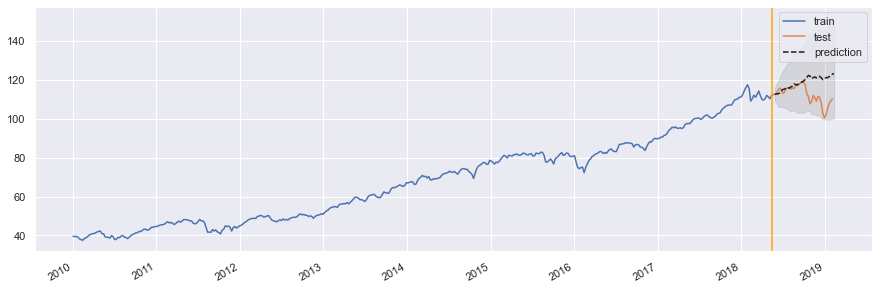

In [21]:
ts_analysis(df, _resampling = '1W', _debug = False, _plot = True)

                                     SARIMAX Results                                     
Dep. Variable:                                 0   No. Observations:                  101
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 9)   Log Likelihood                 193.397
Date:                           Sat, 13 May 2023   AIC                           -376.794
Time:                                   23:13:03   BIC                           -364.239
Sample:                               01-31-2010   HQIC                          -371.729
                                    - 05-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2512      0.711     -0.353      0.724      -1.645       1.143
ma.L1          0.3929      0.677      0.580

9.5068

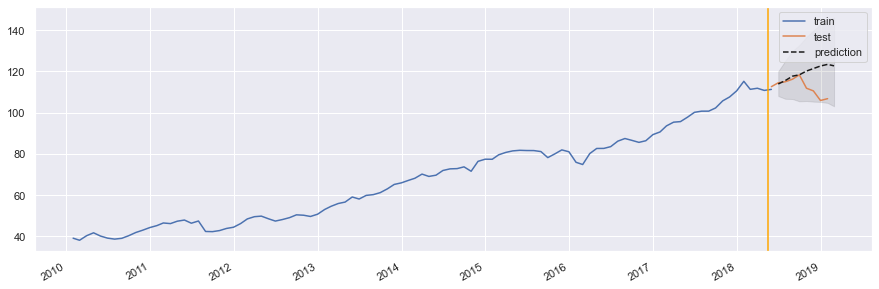

In [22]:
ts_analysis(df, _resampling = '1M', _debug = False, _plot = True, _export = True)

In [23]:
# check export

_export_filename='ts_model_save.sav'
    
loaded_model = pickle.load(open(root_dir + '\\' + _export_filename, 'rb'))
print(loaded_model.summary())



                                     SARIMAX Results                                     
Dep. Variable:                                 0   No. Observations:                  101
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 9)   Log Likelihood                 193.397
Date:                           Sat, 13 May 2023   AIC                           -376.794
Time:                                   23:13:04   BIC                           -364.239
Sample:                               01-31-2010   HQIC                          -371.729
                                    - 05-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2512      0.711     -0.353      0.724      -1.645       1.143
ma.L1          0.3929      0.677      0.580

In [24]:
def lin_analysis(_df = df, _resampling='1W', _debug=False, _method = 0, _plot = True,
                 _export = False, 
                _export_filename='lin_model_save.sav'):
    """
    linear regression method based forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , 0: RandomForestRegressior, 1: Naiv, 2: Sesional naiv, 3: direct with RFR
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename, works only with method 0 !
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months TODO: lags is not used, but should be instead of steps
        steps = 12
    elif _resampling == '1W':
        lags = 156
        steps = 52
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52

    # resampling
    df_resampled = _df.resample(_resampling).mean() 
    
    # create data frame
    df_lin = pd.DataFrame(df_resampled,index=df_resampled.index)
    df_lin['Time'] = np.arange(len(df_lin.index))
    df_lin.columns = ['Stock','Time']
    
    # create month/year as variable
    df_lin['Month'] = df_lin.index.month
    df_lin['Year'] = df_lin.index.year
    
    # create lags as variable
    for i in range(12,18,1):
        df_lin['Lag_'+ str(i)] = df_lin.Stock.shift(i)
    df_lin['Lag_24'] = df_lin.Stock.shift(24)
    
    # remove nan-s due to lags
    df_lin = df_lin.dropna(axis=0)

    # train test split
    df_train_lin, df_test_lin = split_df_prediciton(df_lin,_resampling = _resampling)
    
    # overwrite steps -- TODO not used, remove
    steps = df_test_lin.shape[0]

    # split of target variables from features
    X_train = df_train_lin[df_train_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
    y_train = df_train_lin['Stock']
    
    # split of target variables from features
    X_test = df_test_lin[df_test_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
    y_test = df_test_lin['Stock']
    
    if _method == 0:
        # Random forest regressor
        
        # model
        model = RandomForestRegressor(n_estimators=100)
        model.fit(X_train, y_train)
        
        # export model
        if _export == True:
            pickle.dump(model, open(root_dir + '\\' + _export_filename, 'wb'))

        # prediction
        y_pred = model.predict(X_test)

        # plot feature importance
        if _debug == True:
            feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            feat_importances.nlargest(15).sort_values().plot(kind='barh', title='Feature Importance');

        rmse =  np.sqrt(mean_squared_error(y_test, y_pred)) 

        # for plot:
        y_pred_plot = y_pred
        y_pred_legend = 'Random Forest Regressor'
        
    elif _method == 1:
        # naiv approach
        
        forecast = np.mean(df_train_lin['Stock'][-lags:]) # was 24 
        y_pred_mean = np.ones(steps,)*forecast # was 12

        rmse =  np.sqrt(mean_squared_error(y_test, y_pred_mean)) 

        # for plot:
        y_pred_plot = y_pred_mean
        y_pred_legend = 'Naiv approach'

    elif _method == 2:
        # sesional
        
        y_pred_seas = df_train_lin['Stock'][-steps:] # was 12
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_seas))

        # for plot:
        y_pred_plot = y_pred_seas
        y_pred_legend = 'Benchmark Seasonal naive'
        
    elif _method == 3:
        for i in range(1,steps,1): # was 12 but it works with 1M only
            df_lin['Lag_'+str(i)] = df_lin.Stock.shift(i)
        
        horizons = steps
        cutoff_index = df_lin.shape[0]-horizons

        predictions = []
        pred_index = []
        y_true_m3 = []
        
        for h in np.arange(1,horizons+1,1):
            train, test = df_lin[(steps*2):cutoff_index], df_lin[cutoff_index:cutoff_index+h] # was 24
            if h != 1:
                if _debug == True:
                    print("Horizon: ", h)
                    print("Columns: ", df_lin.columns[1:-h+1])
                    print("")
                X_train_m3 = train[df_lin.columns[1:-h+1]]
                X_test_m3 = test[df_lin.columns[1:-h+1]]
            else: 
                if _debug == True:
                    print("Horizon: ", h)
                    print("Columns: ", df_lin.columns[1:])
                X_train_m3 = train[df_lin.columns[1:]]
                X_test_m3 = test[df_lin.columns[1:]]
                
            y_train_m3 = train['Stock']
            y_test_m3 = test['Stock']
            
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train_m3, y_train_m3)
            
            y_pred_m3 = model.predict(X_test_m3)
            predictions.append(y_pred_m3[h-1])
            pred_index.append(X_test_m3.index[h-1])
            y_true_m3.append(y_test_m3[h-1])

        rmse = np.sqrt(mean_squared_error(y_true_m3, predictions))

        y_pred_plot = predictions
        y_pred_legend = 'Direct approach with Random Forest Regressor'
        
    else:
        # do nothing, should drop an error
        rmse = 0
        
        y_pred_plot = y_test
        y_pred_legend = 'Empty method'

    
    # plot
    if _plot == True:
        fig, ax = plt.subplots(figsize = (15,5))

        plt.plot(df_train_lin.index, df_train_lin.Stock, c='b', label='train')
        plt.plot(X_test.index, y_test, c='orange', label='test')
        plt.plot(X_test.index, y_pred_plot, c = 'r', label='prediction')
        plt.axvline(x= df_test_lin.index[0], color='orange'); 
        plt.legend()

        plt.xlabel('Time')
        plt.ylabel('Stock')
        plt.title(y_pred_legend)
        plt.show()
    
    return np.round(rmse,4)
    

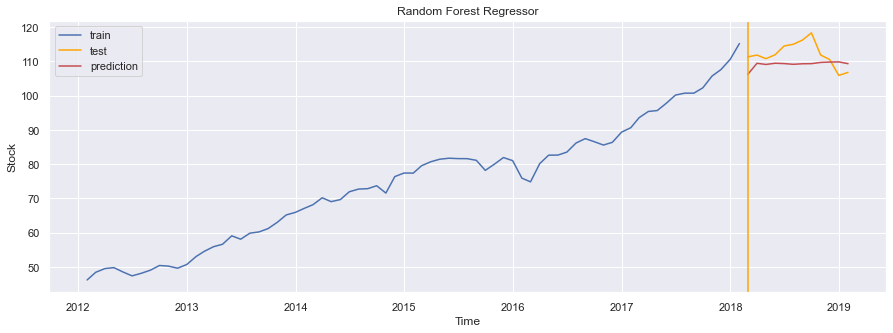

4.628

In [25]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 0, _plot = True, _export = True)

In [26]:
# check export
_export_filename='lin_model_save.sav'
    
loaded_model = pickle.load(open(root_dir + '\\' + _export_filename, 'rb'))

# create data frame again
df_resampled = df.resample('1M').mean() 

# create data frame
df_lin = pd.DataFrame(df_resampled,index=df_resampled.index)
df_lin['Time'] = np.arange(len(df_lin.index))
df_lin.columns = ['Stock','Time']

# create month/year as variable
df_lin['Month'] = df_lin.index.month
df_lin['Year'] = df_lin.index.year

# create lags as variable
for i in range(12,18,1):
    df_lin['Lag_'+ str(i)] = df_lin.Stock.shift(i)
df_lin['Lag_24'] = df_lin.Stock.shift(24)

# remove nan-s due to lags
df_lin = df_lin.dropna(axis=0)

# train test split
df_train_lin, df_test_lin = split_df_prediciton(df_lin,_resampling = '1M')

X_test = df_test_lin[df_test_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
y_test = df_test_lin['Stock']

y_pred = loaded_model.predict(X_test)

 
print(np.sqrt(mean_squared_error(y_test, y_pred))) 



4.6279801756524055


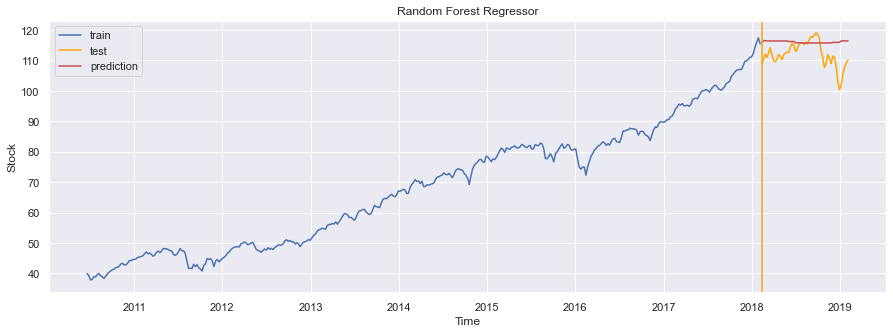

5.7817

In [27]:
lin_analysis(df, _resampling = '1W', _debug = False, _method = 0, _plot = True)

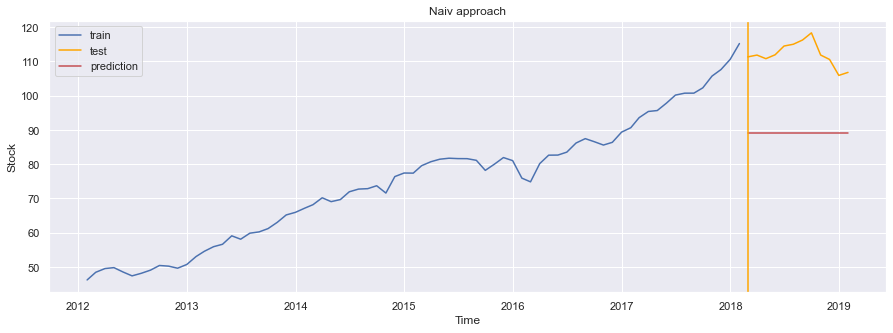

23.2508

In [28]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 1, _plot = True)

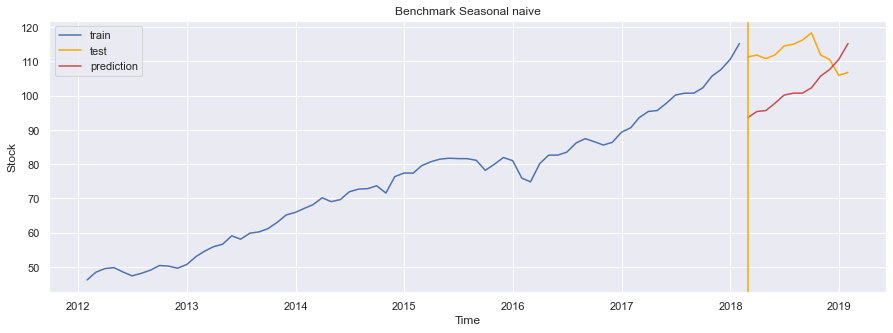

13.086

In [29]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 2, _plot = True)

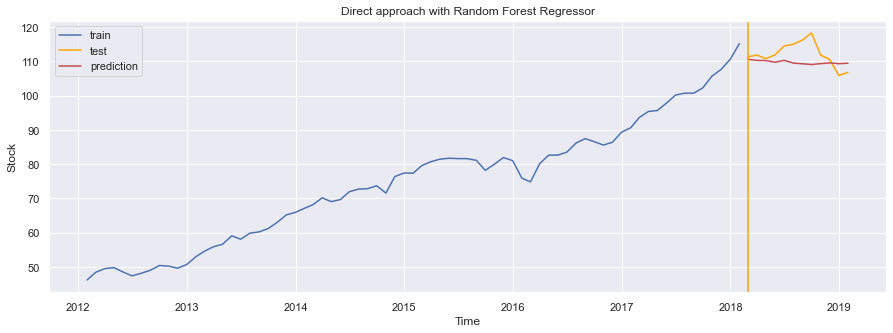

4.2298

In [30]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 3, _plot = True)

In [31]:
def prophet_analysis(_df = df, _resampling='1W', _debug=False, _method = 0, _plot = True,
                 _export = False, 
                _export_filename='pt_model_save.sav'):
    """
    Prophet forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , not used
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename,
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months TODO: lags is not used, but should be instead of steps
        steps = 12
        freq = 'MS'
    elif _resampling == '1W':
        lags = 156
        steps = 52
        freq = 'W'
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52

    # resampling
    df_resampled = _df.resample(_resampling).mean() 
    
    # create data frame ---- train
    df_pt = pd.DataFrame(df_resampled, index=df_resampled.index)
    df_pt['ds'] = df_pt.index
    df_pt.columns = ['y','ds']

    if _debug == True:
        print(df_pt.head())
       
    # remove nan-s -- not needed
    #df_pt = df_pt.dropna(axis=0)

    # train test split
    df_train_pt, df_test_pt = split_df_prediciton(df_pt,_resampling = _resampling)
    
    # overwrite steps -- TODO check
    steps = df_test_pt.shape[0]

    # model creation and fit
    model_pt = pt.Prophet(interval_width=0.95)
    model_pt.fit(df_train_pt)
    # INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
    # INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
    
    # export model
    if _export == True:
        pickle.dump(model_pt, open(root_dir + '\\' + _export_filename, 'wb'))
    
    # prediction DF
    future_dates = model_pt.make_future_dataframe(periods = steps, freq = freq) # TODO MS ws montlhy?
    
    # prediction
    forecast = model_pt.predict(future_dates)
    
    # plot model component
    if _debug == True: 
        model_pt.plot_components(forecast)

    if _debug == True:
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

    # model plot
    if _plot == True:
        model_pt.plot(forecast, uncertainty=True,figsize = (15,5))

        #ax = y_save.plot()
        plt.plot(df_test_pt.index, df_test_pt['y'], c='orange', label='test')
        plt.axvline(x= df_test_pt.index[0], color='orange'); 

    # RSME calculation
    rmse =  np.sqrt(mean_squared_error(df_test_pt['y'], forecast.trend.tail(steps)))
    
    return np.round(rmse,4)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8.3586

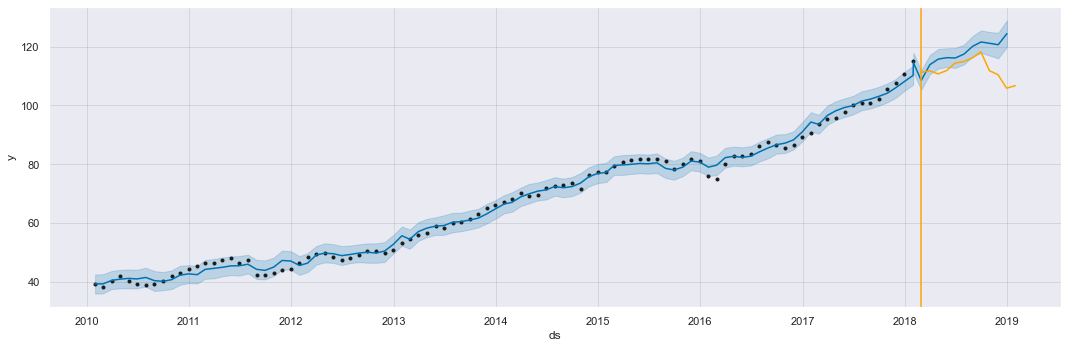

In [32]:
prophet_analysis(df, _resampling = '1M', _debug = False, _method = 0, _plot = True, _export = True)

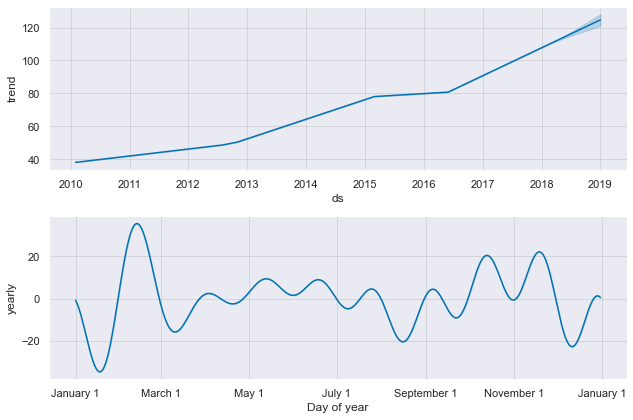

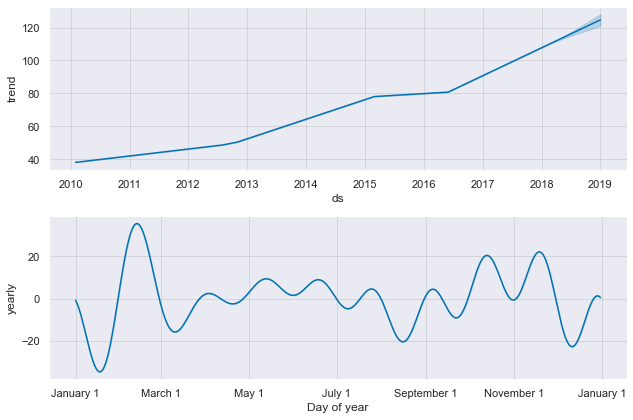

In [33]:
# check export
_export_filename='pt_model_save.sav'
    
loaded_model = pickle.load(open(root_dir + '\\' + _export_filename, 'rb'))
# prediction DF
future_dates = loaded_model.make_future_dataframe(periods = 12, freq = 'MS') 

# prediction
forecast = loaded_model.predict(future_dates)

# plot model component
loaded_model.plot_components(forecast)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11.5033

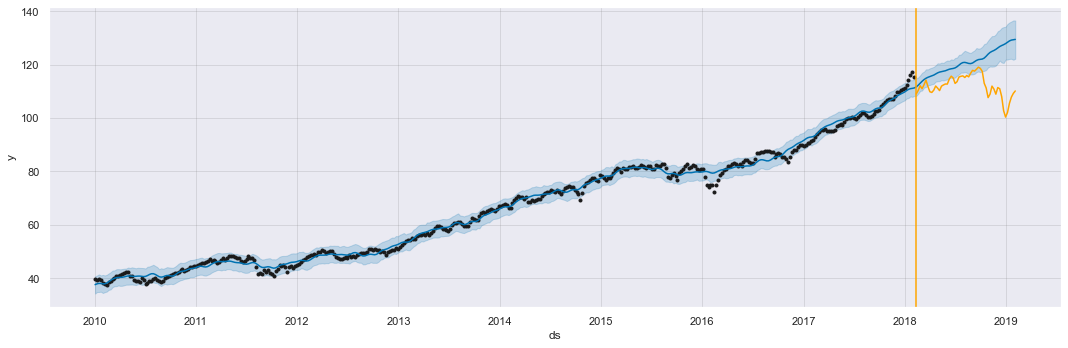

In [34]:
prophet_analysis(df, _resampling = '1W', _debug = False, _method = 0, _plot = True)

In [ ]:
def deepl_analysis(_df = df, _resampling='1W', _debug=False, _method = 0, _plot = True,
                 _export = False, 
                _export_filename='dl_model_save.sav'):
    """
    deep learning forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , not used
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename,
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    
    # TODO DL part
    
    # RSME calculation
    rmse =  0 
    
    return np.round(rmse,4)


In [ ]:
#################################
# NOTHING HAS BEEN DONE TO ANY CODE FURTHER BELOW
#################################

In [ ]:
# this class can be used as standardized output of all analysis functions, including data for plot
# TODO conflicts with built in plots
# TODO lin reg
class result_analysis:
    def __init__(self, rsme, pred, pred_ci_l, pred_ci_u, df_train):
        self.rsme = rsme
        self.prediction_mean = pred
        self.prediction_ci_lower = pred_ci_l
        self.prediction_ci_upper = pred_ci_u
        self.df_train = df_train # resampled
        self.df_test = df_test # resampled
        #df_test.index[0] 
